=== Optimal MR (balanced C* & Isp) ===
Mixture Ratio (O/F) = 2.370
Isp_vac = 301.08 s
C* = 1786.51 m/s


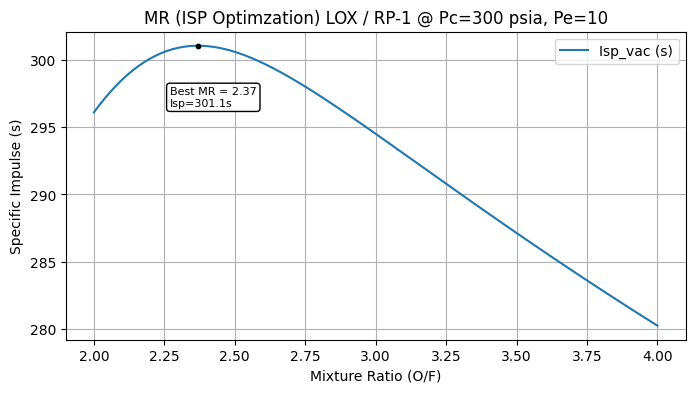

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from rocketcea.cea_obj_w_units import CEA_Obj
from rocketisp.geometry import Geometry, Nozzle
from rocketisp.geometry import solidCylVol, solidFrustrumVol
from scipy.optimize import fsolve, minimize
import math

Pc = 300           
Pe = 10
MR_min = 2               
MR_max = 4             
MR_step = 0.01             

# Create CEA object for LOX/RP-1
rocket = CEA_Obj(oxName='LOX', fuelName='RP-1', temperature_units='degK',
 cstar_units='m/s', specific_heat_units='kJ/kg degK',
 sonic_velocity_units='m/s', enthalpy_units='J/kg',
 density_units='kg/m^3')

# Arrays to store results
mrs = np.arange(MR_min, MR_max + MR_step, MR_step)
isp_vac_list = []
cstar_list = []

# Get optimal expansion ratio for given Pc and Pe at a mid-range MR


# Sweep mixture ratios
for mr in mrs:
    eps = rocket.get_eps_at_PcOvPe(Pc, mr, Pc/Pe, 1, 1)
    IspVac, Cstar, _, _, _ = rocket.get_IvacCstrTc_ChmMwGam(Pc=Pc, MR=mr, eps=eps)
    isp_vac_list.append(IspVac)
    cstar_list.append(Cstar)

# Convert to numpy arrays
isp_vac = np.array(isp_vac_list)

# Combined score (simple product)

# Find MR with max combined score
best_idx = np.nanargmax(isp_vac)
best_mr = mrs[best_idx]
best_isp = isp_vac[best_idx]
best_cstar = cstar_list[best_idx]

print("=== Optimal MR (balanced C* & Isp) ===")
print(f"Mixture Ratio (O/F) = {best_mr:.3f}")
print(f"Isp_vac = {best_isp:.2f} s")
print(f"C* = {best_cstar:.2f} m/s")

# Plot results
plt.figure(figsize=(8,4))
plt.plot(mrs, isp_vac, label='Isp_vac (s)')
plt.xlabel('Mixture Ratio (O/F)')
plt.ylabel('Specific Impulse (s)')
plt.title(f'MR (ISP Optimzation) LOX / RP-1 @ Pc={Pc} psia, Pe={Pe}')
plt.scatter(best_mr, best_isp, color='black', s=10, edgecolors='black', zorder=5)

# Text label without arrow
plt.text(best_mr-0.1, best_isp-4.5,
         f'Best MR = {best_mr:.2f}\nIsp={best_isp:.1f}s',
         fontsize=8,
         bbox=dict(boxstyle="round", fc="w"))
plt.grid(True)
plt.legend()
plt.show()




In [19]:
thrust = 2500  # Desired thrust in lbf
cstar_eff = 0.92  # C* efficiency
p_amb = 14.7  # Ambient pressure in psia
Ct = rocket.getFrozen_PambCf(p_amb, Pc, best_mr, eps,1)  # Thrust coefficient
exhaust_velocity = Ct[0] * best_cstar * cstar_eff  # Exhaust velocity in m/s

mdot = thrust * 4.44822 / exhaust_velocity  # Mass flow rate in kg/s
fuel_mdot = mdot / (1 + best_mr)  # Fuel mass flow rate in kg/s
oxidizer_mdot = mdot - fuel_mdot  # Oxidizer mass flow rate in kg/s

Tc,Tt,Te = rocket.get_Temperatures(Pc, best_mr, eps, 1, 1) # Throat temperature in K
Pt = Pc * 6894.76 / rocket.get_Throat_PcOvPe(Pc, best_mr)  # Throat pressure in Pa
mw, specific_heat_ratio = rocket.get_Throat_MolWt_gamma(Pc, best_mr, eps, 1) # Molecular weight and Specific Heat Ratio at throat
R = 8314.5 / mw  # Specific gas constant in J/(kg·K)

throat_area = (mdot/Pt) * np.sqrt(Tt*R/specific_heat_ratio) * ((specific_heat_ratio+1)/2) ** ((specific_heat_ratio+1)/(2*(specific_heat_ratio-1))) * 1550 # Throat area in in²
throat_radius = np.sqrt(2*throat_area/np.pi) # Throat radius in in

isp_amb,_ = rocket.estimate_Ambient_Isp(Pc,best_mr, eps, p_amb, 1, 1)


print("\n=== Engine Sizing ===")
print(f"Thrust = {thrust} lbf")
print(f"Chamber Pressure = {Pc} psia")
print(f"Chamber Temperature = {Tc:.3f} K")
print(f"C* Efficiency = {cstar_eff*100:.1f} %")
print(f"Exit Pressure = {Pe} psia")
print(f"Expansion Ratio = {eps:.2f}")
print(f"Optimal Mixture Ratio (O/F) = {best_mr:.2f}")
print(f"Vacuum Specific Impulse  = {best_isp:.2f} s")
print(f"Ambient Specific Impulse = {isp_amb:.2f} s")
print(f"Characteristic Velocity (C*) = {best_cstar:.2f} m/s")
print(f"Thrust Coefficient = {Ct[0]:.3f}")
print(f"Exhaust Velocity = {exhaust_velocity:.2f} m/s")
print(f"Mass Flow Rate = {mdot:.3f} kg/s")
print(f"Fuel Flow Rate = {fuel_mdot:.3f} kg/s")
print(f"Oxidizer Flow Rate = {oxidizer_mdot:.3f} kg/s")
print(f"Throat Area = {throat_area:.3f} in²")
print(f"Throat Radius = {throat_radius:.3f} in")


=== Engine Sizing ===
Thrust = 2500 lbf
Chamber Pressure = 300 psia
Chamber Temperature = 3458.033 K
C* Efficiency = 92.0 %
Exit Pressure = 10 psia
Expansion Ratio = 4.70
Optimal Mixture Ratio (O/F) = 2.37
Vacuum Specific Impulse  = 301.08 s
Ambient Specific Impulse = 251.32 s
Characteristic Velocity (C*) = 1786.51 m/s
Thrust Coefficient = 1.458
Exhaust Velocity = 2396.11 m/s
Mass Flow Rate = 4.641 kg/s
Fuel Flow Rate = 1.377 kg/s
Oxidizer Flow Rate = 3.264 kg/s
Throat Area = 10.204 in²
Throat Radius = 2.549 in


In [ ]:

T_pre = 300  # Pre-chamber temperature in K
CR = 3.017 * throat_radius**(-0.6) + 1.25

def area_to_mach(A_over_Astar, specific_heat_ratio, subsonic=True):
    def f(M):
        return (1/M)*((2/(specific_heat_ratio+1)*(1+(specific_heat_ratio-1)/2*M**2))**((specific_heat_ratio+1)/(2*(specific_heat_ratio-1)))) - A_over_Astar
    M_guess = 0.3 if subsonic else 2.0
    M_solution = fsolve(f, M_guess)[0]
    return M_solution

def rayleigh_loss_factor(M_pre, T0_ratio, K=0.3):
    loss_factor = math.exp(-K * (T0_ratio - 1) * M_pre**2)
    return loss_factor

# Contraction Loss Factor
def contraction_loss_factor(alpha_deg, k_alpha=0.02):
    return math.exp(-k_alpha * (alpha_deg / 30.0)**2)

def stagnation_pressure_loss_factor(alpha_deg, CR, gamma, T0_ratio, K=0.3, k_alpha=0.02, blockage_frac=0.02):
    M_pre = area_to_mach(CR, gamma, subsonic=True)
    L_R = rayleigh_loss_factor(M_pre, T0_ratio, K=K)
    L_C = contraction_loss_factor(alpha_deg, k_alpha=k_alpha)
    L_B = max(1.0 - blockage_frac, 0.0)
    return L_R * L_C * L_B


In [97]:
# Parameter Optimization Weights
a = 15 # surface area weight
d = 20 # loss factor weight
e = 35 # volume weight

Rc_Rt = 1 # Chamber to Throat Radius Ratio
Rtc_Rt = 1 # Chamber to Contraction Radius Ratio

cr_range = np.arange(2, 4.0, 0.1) # Contraction Ratio range
conv_half_angle_range = np.arange(20, 60, 1) # Half-Angle range in degrees
Lstar_range = np.arange(40, 50, 5) # Characteristic Length range in in

Vc_range = throat_area * Lstar_range # Chamber Volume range in in³

# Minimum Geometry
G1 = Geometry(Rthrt=throat_radius, CR=cr_range[1], RupThroat=Rtc_Rt, RchmConv=Rc_Rt, cham_conv_deg=conv_half_angle_range[0], LchamberInp=10) 

# Maximum Geometry
G2 = Geometry(Rthrt=throat_radius, CR=cr_range[0], RupThroat=Rtc_Rt, RchmConv=Rc_Rt, cham_conv_deg=conv_half_angle_range[1], LchamberInp=10)

# Find Lc for given Vc
def search_Lc(Vc, geo):
    L = np.linspace(0,30,10000)
    dV = 0.05
    for l in range(len(L)):
        geo.reset_attr('LchamberInp', L[l])
        if abs(geo.Vcham - Vc) < dV:
            return geo.Lcham_cyl
    return None

def volume_surface_area(Lc,CR, conv_half_angle_c):
    geo = Geometry(Rthrt=throat_radius, CR=CR, RupThroat=Rtc_Rt, RchmConv=Rc_Rt, cham_conv_deg=conv_half_angle_c, LchamberInp=10)
    total_length = Lc + geo.Lcham_conv
    geo.reset_attr('LchamberInp', total_length)
    vol_cylinder = solidCylVol(geo.Dinj, geo.Lcham_cyl)
    noz = geo.getNozObj()
    x = np.array(noz.abs_zContour)
    r = np.array(noz.abs_rContour)
    ind_convergent = x <= 0
    x_convergent = x[ind_convergent]
    y_convergent = r[ind_convergent]
    dx_convergent = np.diff(x_convergent)
    dy_convergent = np.diff(y_convergent)

    convergent_volume = np.pi * np.sum((y_convergent[:-1]**2 + y_convergent[1:]**2) / 2 * dx_convergent)
    volume = vol_cylinder + convergent_volume

    ds = np.sqrt(dx_convergent**2 + dy_convergent**2)
    surface_convergent = np.sum(2 * np.pi * (y_convergent[:-1] + y_convergent[1:]) / 2 * ds)
    chamber_surface = 2 * geo.Lcham_cyl * np.sqrt(np.pi * geo.CR * geo.At)
    surface_area = surface_convergent + chamber_surface

    return volume, surface_area

def cost_optimization(x):
    Lc, CR, conv_half_angle_c = x
    volume, surface = volume_surface_area(Lc, CR, conv_half_angle_c)
    loss_factor = stagnation_pressure_loss_factor(conv_half_angle_c, CR, specific_heat_ratio, T0_ratio, K=0.3, k_alpha=0.02, blockage_frac=0.02)
    cost = (a * surface) / (e * volume + d * (loss_factor))
    return cost

def cost_determination(Lc, CR, conv_half_angle_c):
    volume, surface = volume_surface_area(Lc, CR, conv_half_angle_c)
    loss_factor = stagnation_pressure_loss_factor(conv_half_angle_c, CR, specific_heat_ratio, T0_ratio, K=0.3, k_alpha=0.02, blockage_frac=0.02)
    return surface, volume, loss_factor

lc_range = np.array([search_Lc(Vc_range[0],G1), search_Lc(Vc_range[1], G2)])
lc_range = np.around(lc_range,1)

bounds = [(lc_range[0], lc_range[1]), (cr_range[0], cr_range[1]), (conv_half_angle_range[0], conv_half_angle_range[1])]
x0 = np.array([8, 3.6, 37.5]) 

result = minimize(cost_optimization, x0, bounds=bounds, method='SLSQP')
Lc_opt, cr_opt, conv_angle_opt = np.around(result.x, 1)

surface, volume, loss_factor = cost_determination(Lc_opt, cr_opt, conv_angle_opt)

G_opt = Geometry(Rthrt=throat_radius, CR=cr_opt, RupThroat=Rtc_Rt, RchmConv=Rc_Rt, cham_conv_deg=conv_angle_opt, LchamberInp=10, pcentBell=80)
L_total = Lc_opt + G_opt.Lcham_conv

inlet_radius = np.sqrt(cr_opt) * throat_radius

print("\n=== Optimal Converging Section Design ===")
print(f"Optimal Chamber Length = {Lc_opt:.1f} in")
print(f"Optimal Contraction Ratio (CR) = {cr_opt:.2f}")
print(f"Optimal Half-Angle = {conv_angle_opt:.2f} degrees")
print(f"Optimal Total Length = {L_total:.3f} in")
print(f"Surface Area = {surface:.2f} in²")
print(f"Volume = {volume:.2f} in³")
print(f"Rayleigh Loss Factor = {loss_factor:.3f}")
print(f"Corrected Mass Flow Rate = {mdot * loss_factor:.3f} kg/s")
print(f"Inlet Radius = {inlet_radius:.3f} in")




=== Optimal Converging Section Design ===
Optimal Chamber Length = 8.5 in
Optimal Contraction Ratio (CR) = 2.10
Optimal Half-Angle = 21.00 degrees
Optimal Total Length = 12.427 in
Surface Area = 278.00 in²
Volume = 486.53 in³
Rayleigh Loss Factor = 0.737
Corrected Mass Flow Rate = 3.422 kg/s
Inlet Radius = 3.693 in


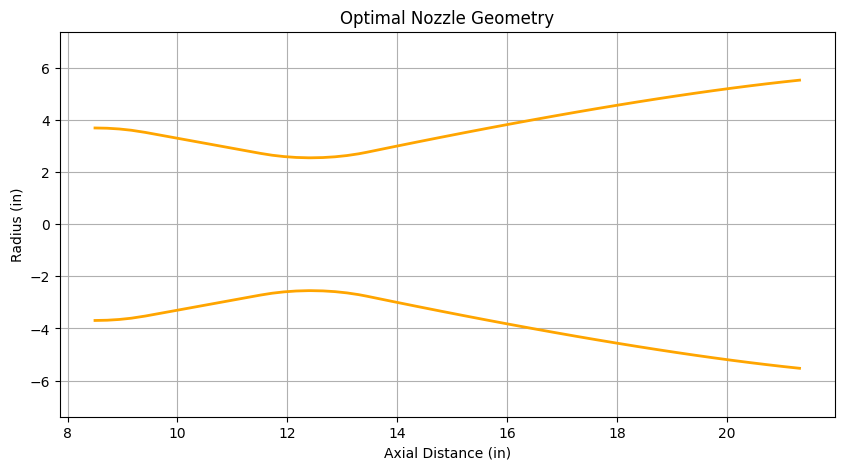

In [ ]:
theta_c = np.deg2rad(G_opt.cham_conv_deg)
cyl_x = np.linspace(0, Lc_opt, 400)
cyl_r = np.ones(len(cyl_x)) * inlet_radius
plt.figure(figsize=(10,5))
plt.title('Optimal Nozzle Geometry')
plt.xlabel('Axial Distance (in)')
plt.ylabel('Radius (in)')
plt.ylim(-2*cyl_r[0],2*cyl_r[0])
plt.grid(True)
plt.plot(cyl_x, cyl_r, linewidth=2, color='red')
plt.plot(cyl_x, -cyl_r, linewidth=2, color='red')

noz = Nozzle(CR=cr_opt, eps= eps, pcentBell=80, Rt= throat_radius, Rup=Rtc_Rt, Rd= 1, cham_conv_ang= conv_angle_opt, Rc= Rc_Rt, theta=23.57, exitAng=12.33)
x = np.array(noz.abs_zContour)
r = np.array(noz.abs_rContour)
inds = np.argsort(x)
x = x[inds]
r = r[inds]
plt.plot(x + L_total, r, linewidth=2, color='orange')
plt.plot(x + L_total, -r, linewidth=2, color='orange')
